# 1. Install & Import Dependencies

In [ ]:
!pip install statsmodels
!pip install pmdarima
!pip install prophet
!pip install tensorflow
!pip install sklearn

!pip install yfinance

In [178]:
import os
import time
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

import yfinance as yfi

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima # SARIMA Model

from prophet import Prophet

%matplotlib inline

# 2. Reading & Process Data

## 2.1. Examin The Data

In [179]:
yahoo_data = yf.Ticker("^GSPC")

# df = yahoo_data.history(period='max')
df = yahoo_data.history(start='1990-01-01', end=datetime.datetime.today())
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [180]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,0.0,0.0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,0.0,0.0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,0.0,0.0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,0.0,0.0
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,0.0,0.0


<Axes: xlabel='Date'>

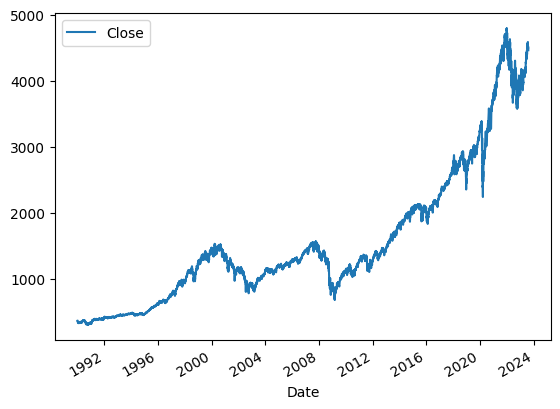

In [181]:
df.plot.line(y='Close', use_index=True)

In [182]:
del df['Dividends']
del df['Stock Splits']

In [183]:
df['Tomorrow'] = df['Close'].shift(-1)

In [184]:
df.tail()

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
2023-08-07 00:00:00-04:00,4491.580078,4519.839844,4491.149902,4518.439941,3493920000,4499.379883
2023-08-08 00:00:00-04:00,4498.029785,4503.310059,4464.390137,4499.379883,3884910000,4467.709961
2023-08-09 00:00:00-04:00,4501.569824,4502.439941,4461.330078,4467.709961,3803100000,4468.830078
2023-08-10 00:00:00-04:00,4487.160156,4527.370117,4457.919922,4468.830078,4504370000,4464.049805
2023-08-11 00:00:00-04:00,4450.689941,4476.229980,4443.979980,4464.049805,3753290000,NaN


In [185]:
df['Target'] = (df['Tomorrow'] > df['Close']).astype('int')
# "1" if the price will go up tomorrow
# "0" if the price will go down tomorrow

In [186]:
df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [187]:
q_80 = int(len(df) * 0.8)
q_90 = int(len(df) * 0.95)

df_train = df[:q_90]
# df_val = df[q_80:q_90]
df_test = df[q_90:]

# In time series data we can't use cross validation, because if we use it our results will be amazing when we are training and horrible in the real world, and the reason why is if we use cross validation we will be using future data to predict past data, which is impossible in the real world and it will result in something called"leakage" ehere we are leaking information into the model.

In [188]:
df_train.dtypes

Open        float64
High        float64
Low         float64
Close       float64
Volume        int64
Tomorrow    float64
Target        int64
dtype: object

In [189]:
df_train.index.dtype

datetime64[ns, America/New_York]

In [190]:
df_train.isna().sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Tomorrow    0
Target      0
dtype: int64

In [191]:
df_train.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


In [192]:
returns_df = df['Close'].pct_change().dropna()
# The "returns" are more stationary, to use in ARIMA

In [193]:
df_test.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2021-12-03 00:00:00-05:00,4589.490234,4608.029785,4495.120117,4538.430176,5240070000,4591.669922,1
2021-12-06 00:00:00-05:00,4548.370117,4612.600098,4540.509766,4591.669922,4770800000,4686.750000,1
2021-12-07 00:00:00-05:00,4631.970215,4694.040039,4631.970215,4686.750000,4492400000,4701.209961,1
2021-12-08 00:00:00-05:00,4690.859863,4705.060059,4674.520020,4701.209961,4234600000,4667.450195,0
2021-12-09 00:00:00-05:00,4691.000000,4695.259766,4665.979980,4667.450195,3903840000,4712.020020,1


In [194]:
df_train.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0


<Axes: xlabel='Date'>

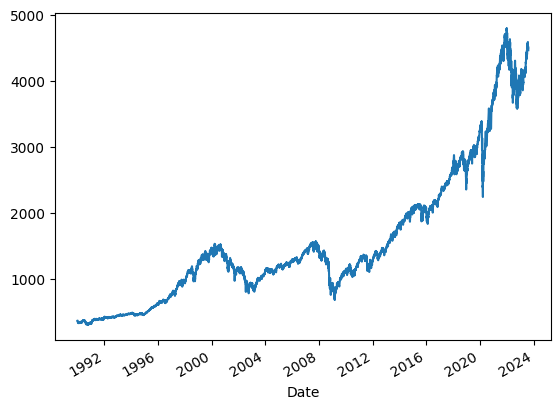

In [195]:
df['Close'].plot()

## 2.3. Convert daily dataset to weekly dataset

The reason why we are converting to weekly timeframe is that higher the timeframe, lower is the noise and hence increases predictability of the model. One can also convert the data to monthly timeframe and check the predictability of the model.

In [196]:
# df_train_w = df_train.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
# df_train_w.head()

In [197]:
# df_test_w = df_test.resample('W').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last'})
# df_test_w.drop(columns=['Open', 'High', 'Low'], inplace=True)

## 2.2. Check for Stationarity

### Conditions
- Mean must be constant
- Variance must be constant
- No seasonality
<img src="https://miro.medium.com/v2/resize:fit:1147/1*xdblkZyg6YmmReAkZHUksw.png" />
An illustration of the principles of stationarity

### Resources
- Stationarity: https://www.youtube.com/watch?v=oY-j2Wof51c


### 2.2.1. ADF Test
We will use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is nan-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So. in our case, if the p-value > 0.05 we'll need to find the order of differencing.

#### Resources
- Unit Roots: https://www.youtube.com/watch?v=ugOvehrTRRw
- ADF Test: https://www.youtube.com/watch?v=1opjnegd_hA

In [198]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    p_value = result[1]
    if p_value <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [199]:
def is_ds_stationary(ds, columns):
    """
    Check if the DataSet columns are "stationary" using the "ADF Test"
    """

    columns_results = {}

    for column in columns:
      result = adfuller(ds[column].dropna(), autolag='AIC') # .dropna() handles differenced data
      # labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
      # out = pd.Series(result[0:4],index=labels)
      # for key,val in result[4].items():
          # out[f'critical value ({key})'] = val
      # print(out.to_string()) # .to_string() removes the line "dtype: float64"

      p_value = result[1]
      columns_results[column] = p_value <= 0.05

    return columns_results

In [200]:
# adf_test(df['Price'])
print(is_ds_stationary(df_train, ['Close', 'Open', 'High', 'Low', 'Volume']))

{'Close': False, 'Open': False, 'High': False, 'Low': False, 'Volume': False}


In [201]:
adf_test(returns_df)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.722174e+01
p-value                 6.273528e-30
# lags used             3.300000e+01
# observations          8.433000e+03
critical value (1%)    -3.431126e+00
critical value (5%)    -2.861883e+00
critical value (10%)   -2.566952e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 2.2.2. Auto-Correlation Function (ACF) & Differencing [Get `d` parameter]

Using a x-order difference of a time series DataFrame is a common technique to transform a non-stationary time series into a stationary one.

Resources
Time series and first differences: https://www.youtube.com/watch?v=nPYPyh20gGo

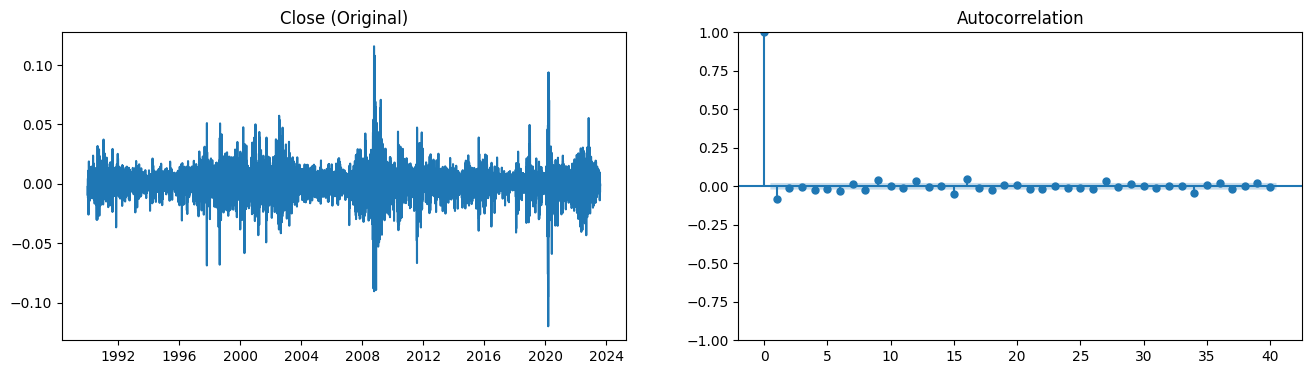

In [202]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(returns_df)
ax1.set_title('Close (Original)')

plot_acf(returns_df, ax=ax2); # Add ";" at the end of the plot function so that the plot isn't duplicated

In [203]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# close_diff_1 = df_train['Close'].diff()

# ax1.plot(close_diff_1)
# ax1.set_title('Close (1st Diff)')

# plot_acf(close_diff_1, ax=ax2); # Add ";" at the end of the plot function so that the plot isn't duplicated

=> The order of differencing is "0"

We can use the `pmdarima` package to get the number of differencing

In [204]:
ndiffs(df_train['Close'], test="adf")

1

### 2.2.3. Partial Auto-Correlation Function (PACF) [Get `p` parameter]
`p` is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictions.

We can find out the required number Of AR terms by inspecting the Partial Autocorrelation (PACF)

The partial autocorrelation represents the correlation between the series and its lags.

In [205]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# price_diff_1 = df_train['Close'].diff()

# ax1.plot(price_diff_1)
# ax1.set_title('Price (1st Diff)')

# ax2.set_ylim(0, 1)
# plot_pacf(price_diff_1, lags=10, ax=ax2); # Add ";" at the end of the plot function so that the plot isn't duplicated

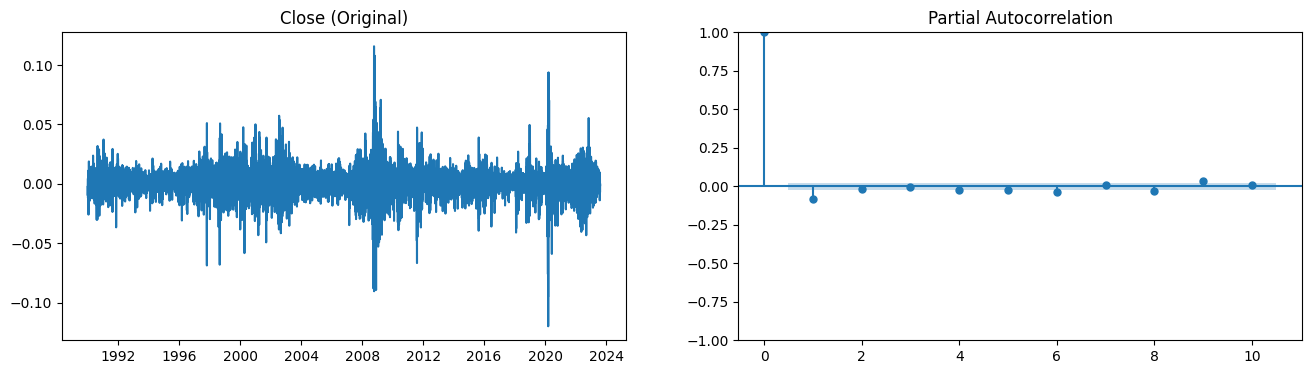

In [206]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(returns_df)
ax1.set_title('Close (Original)')

plot_pacf(returns_df, lags=10, ax=ax2); # Add ";" at the end of the plot function so that the plot isn't duplicated

### 2.2.4. Partial Auto-Correlation Function (PACF) [Get `q` parameter]
`q` is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA.

We can look at the ACF plot for the number of MA terrns.

# 3. Train Model

## 3.0. Before We Start

### Uni-Variate Algorithms (we will not use them in our training)
- ...

### Multi-Variate Algorithms
- VAR
- ARIMA


## 3.1. Vector Auto Regression (VAR)

### Resources
- https://www.youtube.com/watch?v=5-2C4eO4cPQ
- https://www.youtube.com/watch?v=UQQHSbeIaB0

## 3.2. Autoregressive Integrated Moving Average (ARIMA)

ARIMA models can handle cases where the non-stationarity is due to a unit-root but may not work well at all when non-stationarity is of another form.

### When to use ARIMA?
- Non-Stationary data (else, we use ARMA)
- Univariate data (else, we use VARMA family)
- Need of explainability?

  If we need explainability in modelling we should not use the ARIMA model because its nature is not very explainable. In such situations, we can choose models like exponential smoothing, moving average (MA) etc. the reason behind the less explainability is the combination of three modelling procedures makes it difficult to interpret models with higher values.

- Computational constraints

  With very long time series this model becomes very expensive and slow in computation. The reason for being weak at computation is the moving average and integration part of the model because applying differencing more than once is also a high computational process and the moving average is the linear combination of the errors.  Also sometimes they can perform poorly if we don’t have prior knowledge about choosing the right value of parameters.

- Continuity of the data

  With the ARIMA model, it becomes compulsory to record data points in a regular time interval. If there are missing values in the time series then this model can not be applied to the time series.  The reason behind this problem is we are applying a moving average which moves the window through the time series and finds the trend of the time series. If the trend is broken at a point, it stops working and can cause the models to not perform.

### Parameters
- p: Order of the AR term
- d: Number of differencing required to make the time series stationary
- q: Order of MA term



### Resources
- https://analyticsindiamag.com/5-conditions-when-the-arima-model-should-be-avoided/

In [207]:
from numpy.lib.function_base import disp
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df_train['Close'], order=(1, 0, 1)) # (p, d, q)
arima_result = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [208]:
# print(arima_result.summary())

0    0.467166
dtype: float64 0    21.611823
dtype: float64


(array([9.91297932e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.96519173e-06, 9.31820056e-05,
        7.85306222e-03, 2.27998524e-05]),
 array([-1054.20391792,  -928.79635221,  -803.38878649,  -677.98122078,
         -552.57365507,  -427.16608935,  -301.75852364,  -176.35095793,
          -50.94339221,    74.4641735 ,   199.87173921]),
 <BarContainer object of 10 artists>)

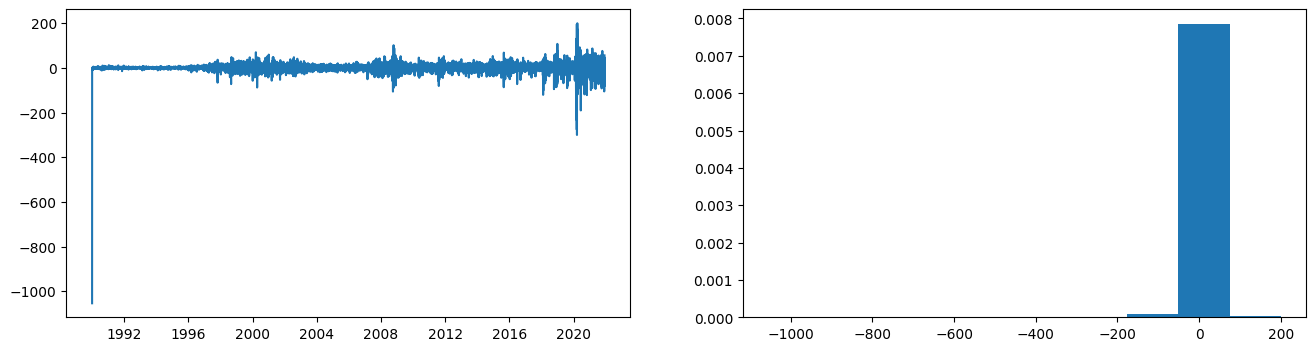

In [209]:
# Plot residual errors
arima_residuals = pd.DataFrame(arima_result.resid)
print(arima_residuals.mean(), arima_residuals.std())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(arima_residuals)
ax2.hist(arima_residuals, density=True)

If the residuals (or errors) of an ARIMA model are close to zero, it suggests that the model is fitting the data well, and the predictions are accurate. Ideally, in a well-fitted ARIMA model, the residuals should be random and have a mean close to zero.

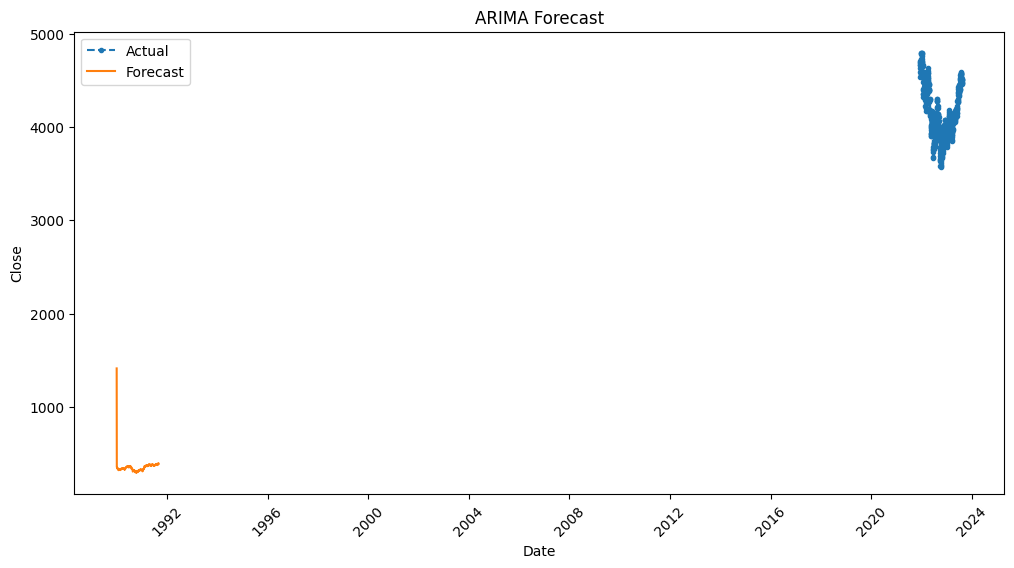

In [210]:
# Actual vs Fitted
arima_predictions = arima_result.predict(0, len(df_test) - 1)
arima_predictions_df = pd.DataFrame({'Close': arima_predictions, 'Date': df_test[:len(arima_predictions)].index})

plt.figure(figsize=(12, 6))
plt.plot(df_test[0:]['Close'], label="Actual", marker='.', linestyle='--')
plt.plot(arima_predictions_df[0:]['Close'], label="Forecast")
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Close")
plt.xticks(rotation=45)
plt.legend()

plt.show()

## 3.3. Seasonal Autoregressive Integrated Moving Average (SARIMA)

In [211]:
sarima_model = auto_arima(
    df_train['Close'],
    seasonal=False,
    error_ignore='ignore',
    suppress_warnings=True,
    stepwise=True,
    approximation=False
  )

In [212]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8044
Model:               SARIMAX(5, 2, 0)   Log Likelihood              -35406.429
Date:                Sun, 13 Aug 2023   AIC                          70824.858
Time:                        10:31:31   BIC                          70866.813
Sample:                             0   HQIC                         70839.215
                               - 8044                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9449      0.004   -266.688      0.000      -0.952      -0.938
ar.L2         -0.6787      0.005   -130.223      0.000      -0.689      -0.668
ar.L3         -0.4825      0.006    -76.222      0.000      -0.495      -0.470
ar.L4         -0.3312      0.006    -51.325      0.000      -0.344      -0.319
ar.L5         -0.1148      0.004    -29.176      0.000      -0.123      -0.107
sigma2       390.7139      1.844    211.911      0.000     387.100     394.328
===================================================================================
Ljung-Box (L1) (Q):                   6.41   Jarque-Bera (JB):            288139.32
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               8.31   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [213]:
# help(auto_arima)

In [214]:
# Predictions
steps = len(df_test)
sarima_forecast = sarima_model.predict(n_periods=steps, return_conf_int=True, alpha=0.05)
sarima_forecast = [
  pd.DataFrame(sarima_forecast[0], columns=['prediction']).reset_index(),
  pd.DataFrame(sarima_forecast[1], columns=['lower_95', 'upper_95'])
]
sarima_forecast = pd.concat(sarima_forecast, axis=1).set_index(df_test.index)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [215]:
sarima_forecast.head()

,index,prediction,lower_95,upper_95
Date,,,,
2021-12-03 00:00:00-05:00,8044,4536.237248,4497.495649,4574.978847
2021-12-06 00:00:00-05:00,8045,4527.960460,4471.640940,4584.279981
2021-12-07 00:00:00-05:00,8046,4508.891408,4432.704458,4585.078359
2021-12-08 00:00:00-05:00,8047,4485.496489,4388.487602,4582.505376
2021-12-09 00:00:00-05:00,8048,4478.995033,4359.607208,4598.382858


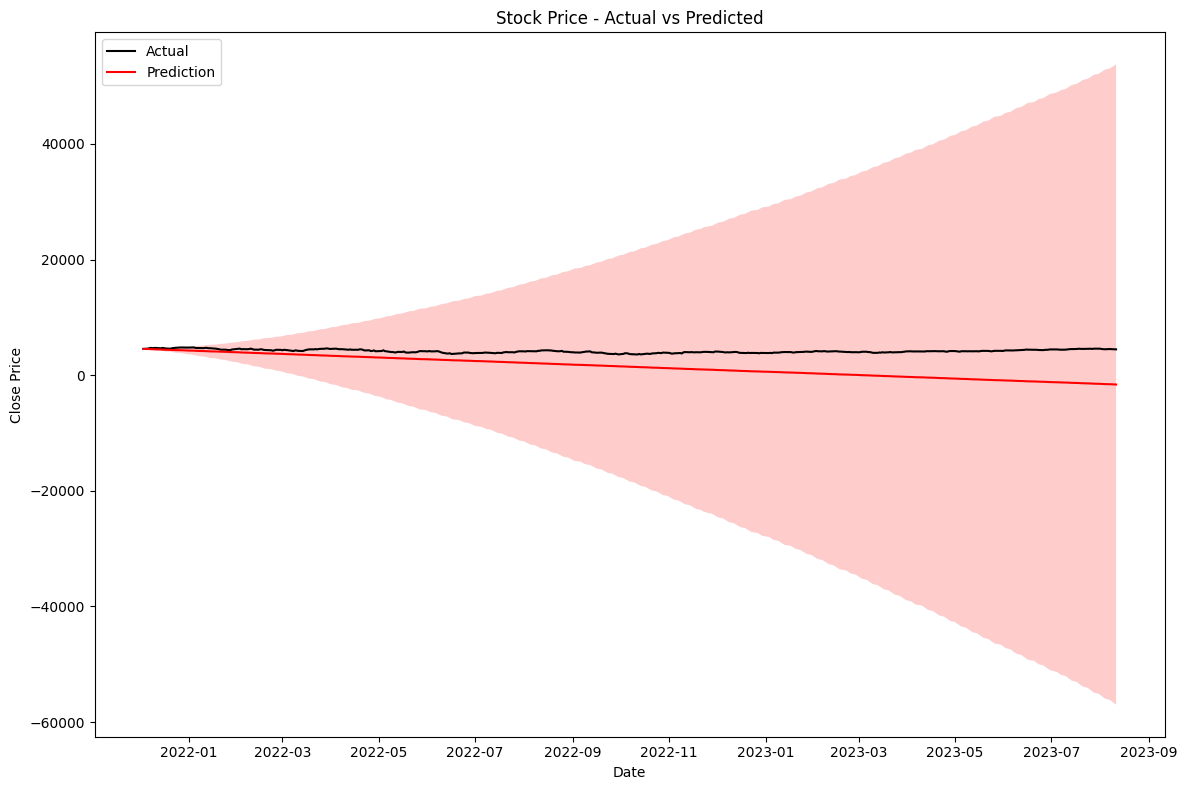

In [216]:
# Visualization
fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=df_test['Close'], color='black', label='Actual')

ax.plot(sarima_forecast['prediction'], color='red', label='Prediction')

ax.fill_between(sarima_forecast.index, sarima_forecast['lower_95'], sarima_forecast['upper_95'], alpha=0.2, facecolor='red')

ax.set(title='Stock Price - Actual vs Predicted', xlabel='Date', ylabel='Close Price')

plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [217]:
# sarima_model.fit(returns_df)
sarima_model.fit(df_train['Close'])

ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [218]:
sarima_forecast = sarima_model.predict(n_periods=steps, return_conf_int=True)
sarima_forecast_df = pd.DataFrame({'Predictions': sarima_forecast[0]})
sarima_forecast_df.set_index(df_test[:steps].index, inplace=True)
# print(sarima_forecast_df)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='Date'>

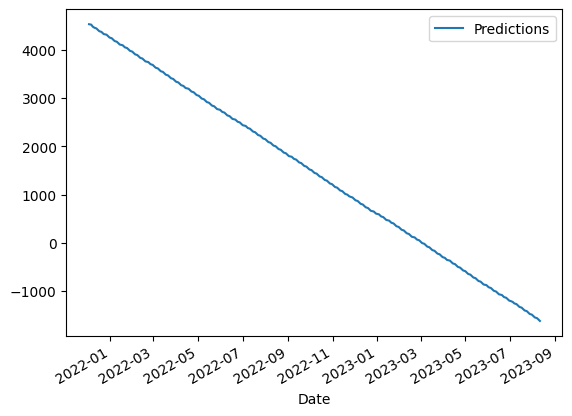

In [219]:
sarima_forecast_df.plot()

## 3.4. Facebook Prophet

**Accurate and Fast:** It is accurate and generate results very fast

**Reliable:** Facebook Company itself uses Prophet for Internal forecasting

**Fully Automatic:** Works with missing data & No need to perform extensive data Preprocessing

**Domain Knowledge Integration:** Forecasting can be made better by adding domain knowledge expertise like holidays & patterns

**Available in R and Python:** We will be using Python Programming Language

### 3.4.1. Data Preparation

In [220]:
# prophet_df = pd.DataFrame(df, columns=['Date', 'Close'])
# prophet_df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
prophet_df = pd.DataFrame()
prophet_df['y'] = df['Close']
prophet_df['ds'] = pd.to_datetime(df.index, format='%Y-%m-%d')
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)

prophet_df = prophet_df.reset_index(drop=True)

In [221]:
# n_split = int(len(prophet_df) * 0.8)
n_split = len(prophet_df) - 30

prophet_df_train = prophet_df[:n_split]
prophet_df_test = prophet_df[n_split:]

In [222]:
print(prophet_df_train)
print(prophet_df_test)

                y         ds
0      359.690002 1990-01-02
1      358.760010 1990-01-03
2      355.670013 1990-01-04
3      352.200012 1990-01-05
4      353.790009 1990-01-08
...           ...        ...
8433  4348.330078 2023-06-23
8434  4328.819824 2023-06-26
8435  4378.410156 2023-06-27
8436  4376.859863 2023-06-28
8437  4396.439941 2023-06-29

[8438 rows x 2 columns]
                y         ds
8438  4450.379883 2023-06-30
8439  4455.589844 2023-07-03
8440  4446.819824 2023-07-05
8441  4411.589844 2023-07-06
8442  4398.950195 2023-07-07
8443  4409.529785 2023-07-10
8444  4439.259766 2023-07-11
8445  4472.160156 2023-07-12
8446  4510.040039 2023-07-13
8447  4505.419922 2023-07-14
8448  4522.790039 2023-07-17
8449  4554.979980 2023-07-18
8450  4565.720215 2023-07-19
8451  4534.870117 2023-07-20
8452  4536.339844 2023-07-21
8453  4554.640137 2023-07-24
8454  4567.459961 2023-07-25
8455  4566.750000 2023-07-26
8456  4537.410156 2023-07-27
8457  4582.229980 2023-07-28
8458  4588.959961 

In [223]:
# prophet_model = Prophet(interval_width=0.95, daily_seasonality=True)
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(prophet_df_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0gw30251/hra_yxxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0gw30251/ano7k1q2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30261', 'data', 'file=/tmp/tmp0gw30251/hra_yxxa.json', 'init=/tmp/tmp0gw30251/ano7k1q2.json', 'output', 'file=/tmp/tmp0gw30251/prophet_modelkc6oqdcv/prophet_model-20230813103134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [224]:
# prophet_future = prophet_model.make_future_dataframe(periods=30)
# prophet_forecast = prophet_model.predict(prophet_future)

prophet_forecast = prophet_model.predict(prophet_df_test)

In [225]:
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-06-30,4501.058711,4280.579815,4654.264396,4501.058711,4501.058711,-33.252430,-33.252430,-33.252430,-27.571011,...,-1.940986,-1.940986,-1.940986,-3.740433,-3.740433,-3.740433,0.0,0.0,0.0,4467.806282
1,2023-07-03,4503.909933,4281.064124,4667.212622,4503.909933,4503.909933,-30.532459,-30.532459,-30.532459,-27.571011,...,-1.427472,-1.427472,-1.427472,-1.533976,-1.533976,-1.533976,0.0,0.0,0.0,4473.377475
2,2023-07-05,4505.810748,4287.622203,4673.765430,4505.810748,4505.810748,-28.438346,-28.438346,-28.438346,-27.571011,...,-1.245006,-1.245006,-1.245006,0.377671,0.377671,0.377671,0.0,0.0,0.0,4477.372402
3,2023-07-06,4506.761156,4287.972864,4670.236100,4506.761156,4506.761156,-27.311694,-27.311694,-27.311694,-27.571011,...,-1.159544,-1.159544,-1.159544,1.418861,1.418861,1.418861,0.0,0.0,0.0,4479.449462
4,2023-07-07,4507.711563,4295.071633,4674.905505,4507.711563,4507.711563,-27.017793,-27.017793,-27.017793,-27.571011,...,-1.940986,-1.940986,-1.940986,2.494204,2.494204,2.494204,0.0,0.0,0.0,4480.693770


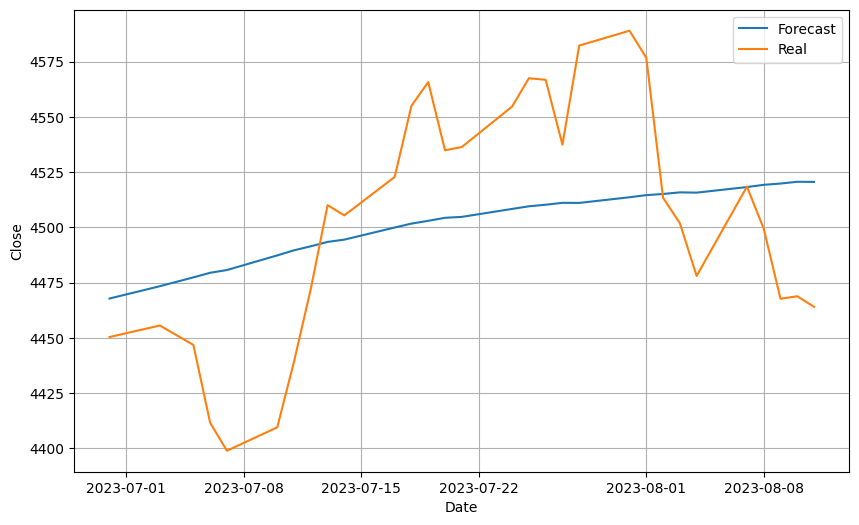

In [226]:
# prophet_model.plot(prophet_forecast, xlabel='ds', ylabel='y', include_legend=True);

plt.figure(figsize=(10, 6))
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Forecast')
plt.plot(prophet_df_test['ds'], prophet_df_test['y'], label='Real')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

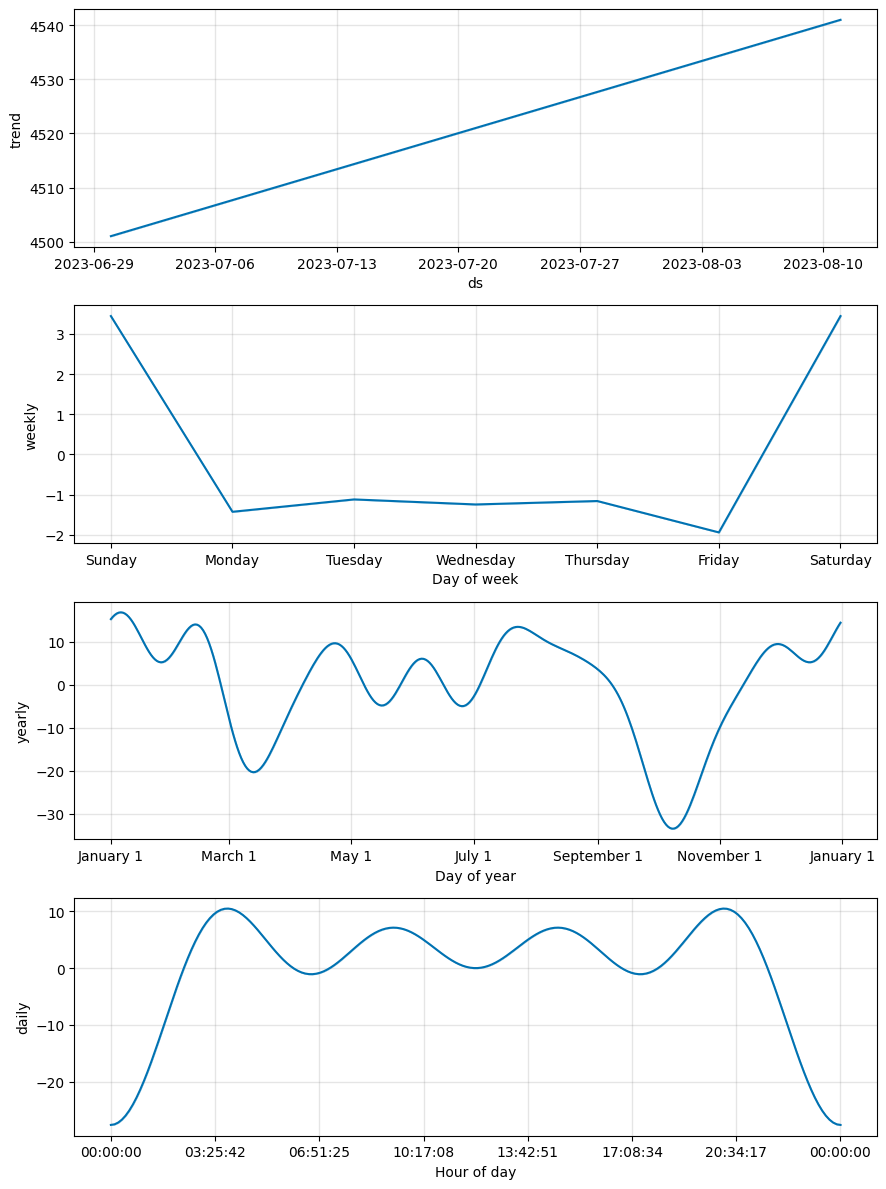

In [227]:
prophet_model.plot_components(prophet_forecast);

## 3.5. Deep Learning - LSTM

In [228]:
def df_to_X_y(df, window_size=5, horizon=5):
  df_as_np = np.array(df)

  X = []
  y = []

  for i in range(len(df_as_np) - window_size - horizon):
    row = df_as_np[i:i + window_size]
    X.append(row)

    labels = df_as_np[i + window_size:i + window_size + horizon]
    # labels = df_as_np[i:i + window_size]
    y.append(labels)

  return np.array(X), np.array(y)

In [229]:
WINDOW_SIZE = 50
HORIZON = 10
X_train, y_train = df_to_X_y(df_train['Close'], WINDOW_SIZE, HORIZON)
X_test, y_test = df_to_X_y(df_test['Close'], WINDOW_SIZE, HORIZON)
# X_val, y_val = df_to_X_y(df_val['Close'], WINDOW_SIZE)

print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7984, 50) (7984, 10)
(364, 50) (364, 10)


In [230]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [231]:
model_1 = Sequential()
model_1.add(InputLayer((WINDOW_SIZE, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(64, 'relu'))
model_1.add(Dense(32, 'relu'))
model_1.add(Dense(HORIZON, 'linear'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 23,466
Trainable params: 23,466
Non-trainable params: 0
_________________________________________________________________


In [232]:
cp = ModelCheckpoint('models/model_1/', save_best_only=True)
model_1.compile(
  loss=MeanSquaredError(),
  optimizer=Adam(learning_rate=0.001),
  metrics=[RootMeanSquaredError()]
)

In [233]:
model_1.fit(
  X_train,
  y_train,
  # validation_data=(X_val, y_val),
  epochs=100,
  # callbacks=[cp],
)

Epoch 1/100
250/250 [==============================] - 13s 42ms/step - loss: 2061323.5000 - root_mean_squared_error: 1435.7310
Epoch 2/100
250/250 [==============================] - 14s 57ms/step - loss: 229439.9531 - root_mean_squared_error: 478.9987
Epoch 3/100
250/250 [==============================] - 13s 52ms/step - loss: 32433.0547 - root_mean_squared_error: 180.0917
Epoch 4/100
250/250 [==============================] - 12s 49ms/step - loss: 24483.0938 - root_mean_squared_error: 156.4708
Epoch 5/100
250/250 [==============================] - 12s 46ms/step - loss: 11460.1631 - root_mean_squared_error: 107.0522
Epoch 6/100
250/250 [==============================] - 13s 53ms/step - loss: 10296.6914 - root_mean_squared_error: 101.4726
Epoch 7/100
250/250 [==============================] - 12s 50ms/step - loss: 5757.7993 - root_mean_squared_error: 75.8801
Epoch 8/100
250/250 [==============================] - 17s 69ms/step - loss: 6632.5938 - root_mean_squared_error: 81.4407
Epoch 9/

In [234]:
# from tensorflow.keras.models import load_model

# model_1 = load_model('models/model_1/')

In [235]:
# train_predictions = model_1.predict(X_train).flatten()

# plt.plot(df_train.index[:len(train_predictions)], train_predictions)
# plt.plot(df_train.index[:len(train_predictions)], y_train)

# plt.legend(['Training Predictions', 'Training Actual'])

In [236]:
# val_predictions = model_1.predict(X_val).flatten()

# plt.plot(df_val.index[:len(val_predictions)], val_predictions)
# plt.plot(df_val.index[:len(val_predictions)], y_val)

# plt.legend(['Validation Predictions', 'Validation Actual'])

In [237]:
# test_predictions = model_1.predict(X_test).flatten()

# plt.plot(df_test.index[:len(test_predictions)], test_predictions)
# plt.plot(df_test.index[:len(test_predictions)], y_test)

# plt.legend(['Testing Predictions', 'Testing Actual'])

In [238]:
from datetime import datetime, timedelta

def generate_dates(start_date_str, end_date_str):
  start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
  # start_date = start_date_str
  end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
  # end_date = end_date_str

  date_list = []
  current_date = start_date

  while current_date <= end_date:
    date_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=1)

  return date_list

In [239]:
def predict_date(data, data_last_date, date_to_predict, window_size):
  predictions = []

  dates = generate_dates(data_last_date, date_to_predict)[1:]

  X = [data[i] for i in range(window_size)]

  for date in dates:
    predicted_value = float(model_1.predict([X]).flatten()[0])
    predictions.append(predicted_value)

    # Remove first element
    X.pop(0)

    # Add the new prediction, so we can predict the next date
    X.append(predictions[-1])

  return dates, np.array(predictions).flatten()

2/2 [==============================] - 0s 5ms/step


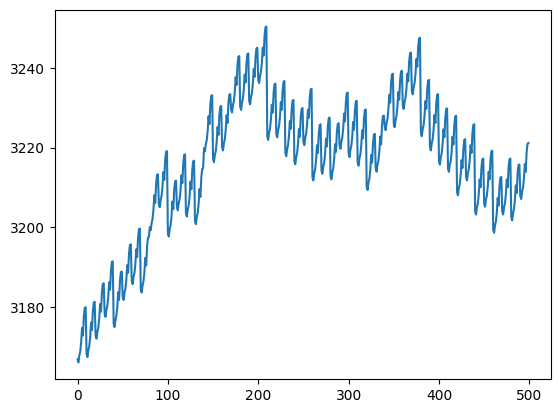

In [240]:
test_pred = model_1.predict([df_train['Close'][:WINDOW_SIZE]]).flatten()

plt.plot(test_pred)

1/1 [==============================] - 0s 39ms/step


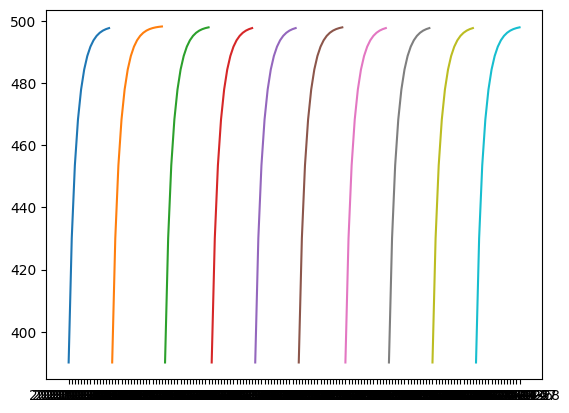

<Axes: xlabel='Date'>

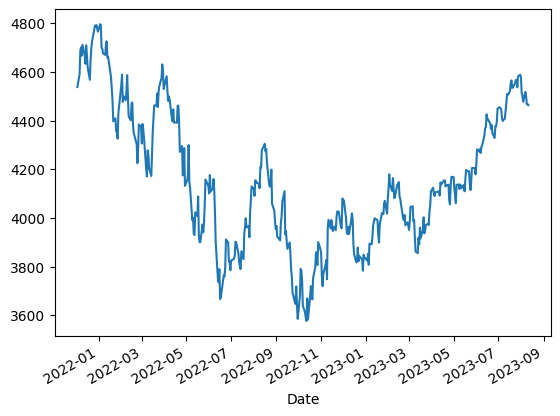

In [241]:
# predicted_dates, predicted_values = predict_date(df['Close'], df.index[-1].strftime('%Y-%m-%d'), '2023-12-20', WINDOW_SIZE)
# predicted_dates, predicted_values = predict_date(df['Close'], '2023-04-01', '2023-05-01', WINDOW_SIZE)
# predicted_dates, predicted_values = predict_date(df['Close'], df_val.index[0].strftime('%Y-%m-%d'), df_val.index[-1].strftime('%Y-%m-%d'), WINDOW_SIZE)

for i in range(10):
  predicted_dates, predicted_values = predict_date(df['Close'], df_test.index[i * 10].strftime('%Y-%m-%d'), df_test.index[(i + 1) * 10].strftime('%Y-%m-%d'), WINDOW_SIZE)
  plt.plot(predicted_dates, predicted_values)

plt.show()

df_test['Close'].plot()

## 3.6. Random Forest Classifier

- Random Forest works by training a bunch of individual desision trees with randomized parameters and then averaging the results from those decision trees. Because of this, Random Forest is harder to overfit.
- Run quickly.
- It can pick up non-linear tendencies in the data.

In [242]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [243]:
# rf_model = RandomForestClassifier(
#   n_estimators=200,
#   min_samples_split=50,
#   random_state=1
# )
rf_model = RandomForestRegressor(
  n_estimators=200,
  min_samples_split=50,
  random_state=1
)
# n_estimators: number of decision trees we want to train
# min_samples_split: this help us to prevent overfitting

In [244]:
rf_predector_columns = ['Volume', 'Open', 'High', 'Low']

In [245]:
rf_column_to_predict = ['Close']

In [246]:
rf_model.fit(df_train[rf_predector_columns], df_train[rf_column_to_predict])

<ipython-input-246-2fac13e1d22c>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(df_train[rf_predector_columns], df_train[rf_column_to_predict])


RandomForestRegressor(min_samples_split=50, n_estimators=200, random_state=1)

In [247]:
from sklearn.metrics import precision_score

rf_predictions = rf_model.predict(df_test[rf_predector_columns])
rf_predictions = pd.Series(rf_predictions, index=df_test.index)

print(rf_predictions)

Date
2021-12-03 00:00:00-05:00    4579.444664
2021-12-06 00:00:00-05:00    4608.519323
2021-12-07 00:00:00-05:00    4610.746692
2021-12-08 00:00:00-05:00    4610.746692
2021-12-09 00:00:00-05:00    4610.746692
                                ...     
2023-08-07 00:00:00-04:00    4494.069101
2023-08-08 00:00:00-04:00    4437.665985
2023-08-09 00:00:00-04:00    4434.775716
2023-08-10 00:00:00-04:00    4450.003455
2023-08-11 00:00:00-04:00    4423.767339
Length: 424, dtype: float64


In [248]:
# precision_score(df_test[rf_column_to_predict], rf_predictions)

<Axes: xlabel='Date'>

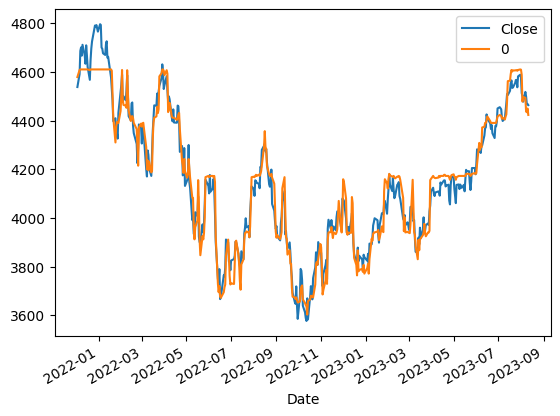

In [249]:
combined = pd.concat([df_test[rf_column_to_predict], rf_predictions], axis=1)
combined.plot()

### Backtesting

In [250]:
def rf_predict(train, test, predictors, model):
  model.fit(train[predictors], train[rf_column_to_predict])

  predictions = model.predict(test[predictors])
  # predictions = model.predict_proba(test[predictors])[:, 1]
  # predictions[predictions >= 0.6] = 1
  # predictions[predictions < 0.6] = 0
  predictions = pd.Series(predictions, index=test.index, name="Predictions")

  combined = pd.concat([test[rf_column_to_predict], predictions], axis=1)
  return combined

In [251]:
def backtest(data, model, predictors, start=2500, step=250):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i + step)].copy()

    predictions = rf_predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [252]:
backtest_predictions = backtest(df, rf_model, rf_predector_columns)

<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predict])
<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predict])
<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predict])
<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predic

In [253]:
# backtest_predictions['Predictions'].value_counts()

In [254]:
# precision_score(backtest_predictions['Target'], backtest_predictions['Predictions'])

In [255]:
# backtest_predictions['Target'].value_counts() / backtest_predictions.shape[0]

<Axes: xlabel='Date'>

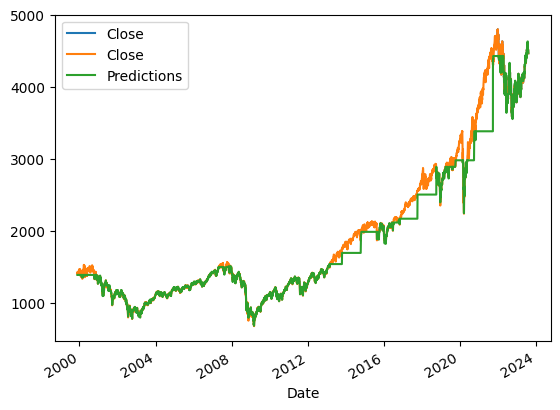

In [256]:
combined = pd.concat([df_test[rf_column_to_predict], backtest_predictions], axis=1)
combined.plot()

In [257]:
horizons = [2, 5, 60, 250, 1000]

new_predictors = []

for horizon in horizons:
  rolling_averages = df.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  df[ratio_column] = df['Close'] / rolling_averages['Close']

  trend_column = f"Trend_{horizon}"
  df[trend_column] = df.shift(1).rolling(horizon).sum()['Target']

  new_predictors += [ratio_column, trend_column]

In [258]:
df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [259]:
df = df.dropna()

In [260]:
df.head()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0


In [261]:
backtest_predictions = backtest(df, rf_model, new_predictors)

<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predict])
<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predict])
<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predict])
<ipython-input-250-2c98e6b57f11>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train[predictors], train[rf_column_to_predic

In [262]:
# backtest_predictions["Predictions"].value_counts()

In [263]:
# precision_score(backtest_predictions[rf_column_to_predict], backtest_predictions['Predictions'])

<Axes: xlabel='Date'>

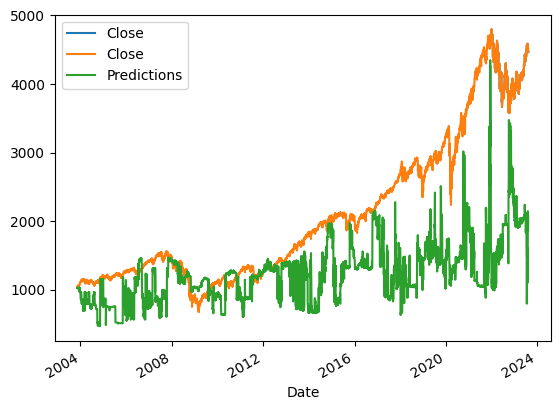

In [264]:
combined = pd.concat([df_test[rf_column_to_predict], backtest_predictions], axis=1)
combined.plot()

## 3.8. Single Exponential Smoothing (SES)

In [268]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [269]:
ses_model = SimpleExpSmoothing(df_train['Close'])
ses_model_fitted = ses_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [270]:
print('coefficients',ses_model_fitted.params)
predictions = ses_model_fitted.predict(start=len(df_train), end=len(df_train) + len(df_test)-1)
print(predictions)

coefficients {'smoothing_level': 0.8749088733491637, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 359.69000244140625, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
8044    4570.092265
8045    4570.092265
8046    4570.092265
8047    4570.092265
8048    4570.092265
           ...     
8463    4570.092265
8464    4570.092265
8465    4570.092265
8466    4570.092265
8467    4570.092265
Length: 424, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


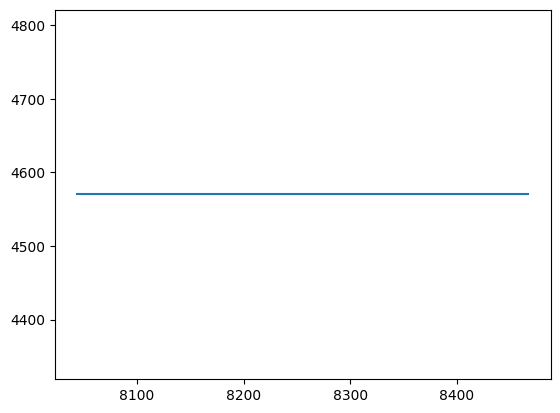

In [271]:
plt.plot(predictions)

-----------------------

Some resources:

- https://www.youtube.com/watch?v=_ZQ-lQrK9Rg